<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/VDSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very Deep Super-Resolution avec le Deep Learning

Description...

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import glob
from skimage.transform import rescale, resize

from PIL import Image

# Téléchargement et chargement des données

Le nombre de données est très grand, le fichier contient 20 000 images et sa taille est d'environ 1,6 Go

In [ ]:
!wget "http://www-i6.informatik.rwth-aachen.de/imageclef/resources/iaprtc12.tgz"
!tar xzf iaprtc12.tgz

In [ ]:
!ls iaprtc12/images/ -l

Affichage d'une image aléatoire dans le répertoire /images/39/

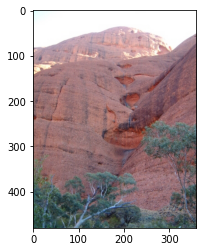

In [7]:
fichier = "iaprtc12/images/39/39"+str(int((random.randrange(0,1000))))+".jpg"
img=mpimg.imread(fichier)
plt.imshow(img)

In [ ]:
img

Chargement des images contenues dans le répertoire /images/39/

In [14]:
def ChargementImages(repertoire):
  images = []
  fichiers = glob.glob(repertoire+"*.jpg")
  for fichier in fichiers:
    img = mpimg.imread(fichier)
    images.append(img)
  return np.array(images, dtype=object)

In [15]:
images = ChargementImages("iaprtc12/images/39/")

In [16]:
images.shape

(916,)

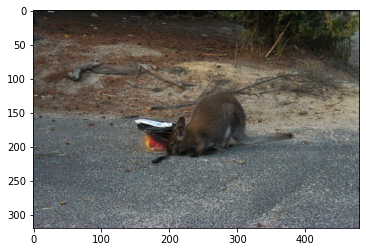

In [17]:
plt.imshow(images[0])

# Préparation des données d'entrainement

Chaque échantillon d'entrainement doit contenir :
 - X : Le canal de luminance de l'image basse résolution traitée par interpolation bicubique : Ybr
 - Y : L'image résiduelle : Yresiduelle = Yhr - Ybr (différence entre la luminance de l'image haute résolution et la luminance de l'image basse résolution traitée par interpolation bicubique)  

Les étapes sont les suivantes :  
- Convertir les images RGB au format YCbCr
- Appliquer un facteur d'échelle aléatoire afin de créer une image basse résolution
- Reconvertir l'image en haute résolution à l'aide de l'interpolation bicubique puis en extraire la luminance. **Ces données seront les échantillons X.**
- Extraire l'image résiduelle (différence entre l'image reconstituée en haute résolution et l'image basse résolution)
- Sauvegarder la luminance de l'image résiduelle. **Ces données seront les échantillons Y.**

**1. Conversion des images RGB au format YCrCb**  
Le [modèle **YCbCr**](https://fr.wikipedia.org/wiki/YCbCr) est une manière de représenter l'espace colorimétrique en vidéo, issue essentiellement des problèmes de transmission hertzienne. Ce standard a été développé à une époque où il fallait assurer la compatibilité des récépteurs de télévision noir et blanc et des récepteurs couleur.  

La couleur étant créée par la juxtaposition de trois types de luminophores rouge (R), vert (anglais : green, G) et bleu (B), il faut transmettre trois composantes, trois signaux. Cependant, le noir et blanc ne comprend qu'une seule teinte, le niveau de gris.  

Les trois signaux transmis ne sont donc pas les trois composantes RGB mais la teinte de gris Y, et la différence entre cette teinte et deux autres composantes.

Les trois informations sont donc la luminance (teinte de gris) et les deux chrominances. Le récepteur noir et blanc ne traitera que la luminance et les récepteurs en couleur déduiront les trois composantes RVB à partir de la luminance et des deux chrominances :  
- La luminance Y : Y = R + G + B (teinte de gris)
- La chrominance Cb : Y - B
- La chrominance Cr : Y - R  

Dans la pratique, les luminophores n'ont pas le même rendement, on applique donc des coefficients correcteurs.

Pour calculer les valeurs des composantes YCbCr d'une image à partir des composantes RVB (qui varient de 0 à 255), on utilise les formules suivantes :  

$\left\{ \begin{array}{l}
Y = 0,299R + 0,587V + 0,114B\\
{C_b} =  - 0,1687R - 0,3313V + 0,5B + 128\\
{C_r} = 0,5R - 0,4187V - 0,0813B + 128
\end{array} \right.$

In [18]:
def rgb2ycbcr(img):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = img.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [19]:
images_YCbCr = []
for img in images:
  images_YCbCr.append(rgb2ycbcr(img))
images_YCbCr = np.array(images_YCbCr,dtype=object)

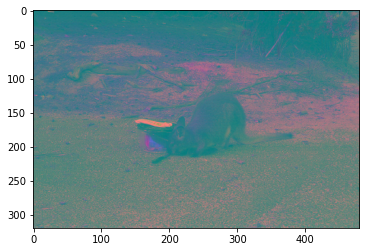

In [20]:
plt.imshow(images_YCbCr[0])

**2. Application d'un facteur d'échelle aléatoire pour créer l'image basse résolution**  
Pour créer l'image basse résolution, nous allons simplement utiliser la fonction resize du [module Image de la librairie Pillow](https://pillow.readthedocs.io/en/stable/reference/Image.html?highlight=resize%20image#module-PIL.Image), avec des échelles aléatoires et une interpolation de type bicubique.

In [91]:
Facteurs = [2,3,4]

images_YCbCr_resize=[]

for img in images:
  FacteurEchelle = random.randrange(min(Facteurs),max(Facteurs)+1)
  img_PIL = Image.fromarray(img)
  img_PIL = img_PIL.resize(((round(img_PIL.size[0]*(1/FacteurEchelle)), round(img_PIL.size[1]*(1/FacteurEchelle)))),Image.BICUBIC)
  images_YCbCr_resize.append(np.array(img_PIL))

In [ ]:
images_YCbCr_resize[0]

Text(0.5, 1.0, 'YCbCr redimensionnée (Echelle 4)')

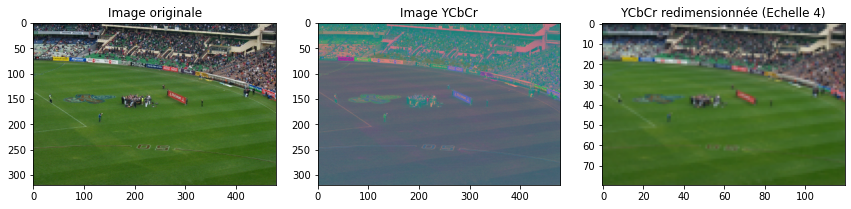

In [93]:
index = random.randrange(0,len(images)+1)

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale")

ax[1].imshow(images_YCbCr[index])
ax[1].set_title("Image YCbCr")

ax[2].imshow(images_YCbCr_resize[index])
ax[2].set_title("YCbCr redimensionnée (Echelle %d)" %(images[index].shape[0]/images_YCbCr_resize[index].shape[0]))

**3. Reconversion de l'image en haute résolution à l'aide de l'interpolation bicubique**  
L'agrandissement des images se fait par interpolation. Il existe différentes méthodes : interpolation par plus proche voisin, interpolation bilinéaire, [interpolation bicubique](https://fr.wikipedia.org/wiki/Interpolation_bicubique).  

Dans le domaine du traitement d'images numériques, l'interpolation bicubique est souvent préférée à une interpolation bilinéaire ou à la technique du plus proche voisin pour le ré-échantillonnage d'images, lorsque le temps de traitement n'est pas critique. Contrairement à une interpolation bilinéaire, qui ne prend que 4 pixels (2 × 2) en compte, l'interpolation bicubique considère un voisinage de 16 pixels (4 × 4). Les images ré-échantillonnées par une interpolation bicubique sont donc plus lisses et ont moins d'artefacts d'interpolation. 

Commençons par créer les agrandissements avec l'interpolation bicubique des images en basse résolution :

In [87]:
images_YCbCr_up_cubic = []

for index in range(0,len(images_YCbCr_resize)):
  Echelle = images[index].shape[0] // images_YCbCr_resize[index].shape[0]
  img_PIL = Image.fromarray(images_YCbCr_resize[index])
  img_PIL = img_PIL.resize(((round(img_PIL.size[0]*(Echelle)), round(img_PIL.size[1]*(Echelle)))),Image.BICUBIC)
  images_YCbCr_up_cubic.append(np.array(img_PIL))

TypeError: ignored

Text(0.5, 1.0, 'YCbCr up cubic')

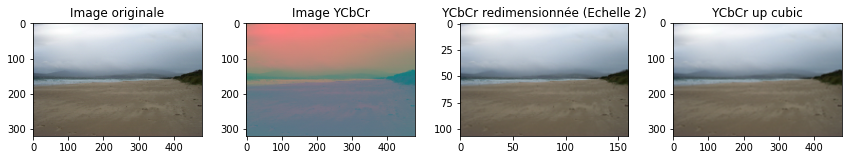

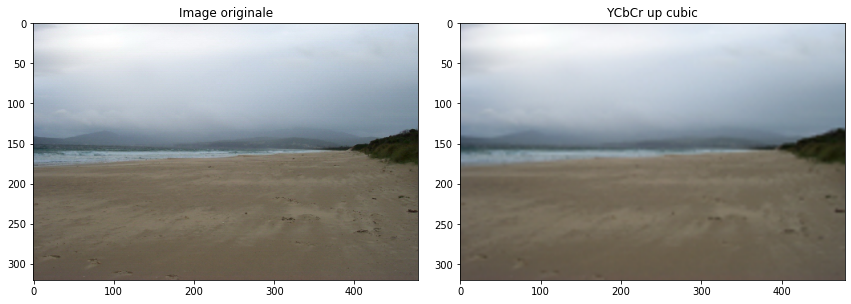

In [69]:
index = random.randrange(0,len(images)+1)

fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale")

ax[1].imshow(images_YCbCr[index])
ax[1].set_title("Image YCbCr")

ax[2].imshow(images_YCbCr_resize[index])
ax[2].set_title("YCbCr redimensionnée (Echelle %d)" %(images[index].shape[0]/images_YCbCr_resize[index].shape[0]))

ax[3].imshow(images_YCbCr_up_cubic[index])
ax[3].set_title("YCbCr up cubic")

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,12))
fig.tight_layout()
ax = axes.ravel()

ax[0].imshow(images[index])
ax[0].set_title("Image originale")

ax[1].imshow(images_YCbCr_up_cubic[index])
ax[1].set_title("YCbCr up cubic")


Maintenant, sauvegardons les images résiduelles :

In [83]:
delta = images[1] - images_YCbCr_up_cubic[1]

In [86]:
images_YCbCr_residuelle = []

for index in range(0,len(images)):
  delta = images[index] - images_YCbCr_up_cubic[index]

ValueError: ignored

In [80]:
images_YCbCr_up_cubic[index]

array([[[ 72, 104, 155],
        [ 72, 104, 155],
        [ 73, 103, 155],
        ...,
        [ 83, 111, 162],
        [ 82, 111, 162],
        [ 82, 111, 162]],

       [[ 72, 104, 155],
        [ 72, 104, 155],
        [ 73, 103, 155],
        ...,
        [ 83, 111, 162],
        [ 82, 111, 162],
        [ 82, 111, 162]],

       [[ 72, 104, 155],
        [ 72, 104, 155],
        [ 74, 103, 155],
        ...,
        [ 83, 111, 162],
        [ 82, 111, 162],
        [ 82, 111, 162]],

       ...,

       [[182, 187, 175],
        [177, 180, 166],
        [164, 161, 143],
        ...,
        [ 21,  27,  25],
        [ 29,  36,  32],
        [ 32,  39,  35]],

       [[180, 186, 172],
        [175, 179, 163],
        [162, 160, 140],
        ...,
        [ 22,  29,  26],
        [ 30,  38,  34],
        [ 33,  41,  37]],

       [[179, 186, 171],
        [174, 179, 162],
        [161, 159, 139],
        ...,
        [ 22,  30,  27],
        [ 31,  39,  35],
        [ 34,  42,  38]]